# Rossmann Store Sales



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

import pylab
import csv
import datetime
import math
import re
import time
import random
import os

from pandas.tseries.offsets import *
from operator import *

from sklearn.cross_validation import train_test_split

%matplotlib inline

# plt.style.use('ggplot') # Good looking plots

np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 100)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)

start_time = time.time()

C:\Users\Administrator\Anaconda2\envs\gl-env\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:

# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

## Setting seed

In [4]:
seed = 42

## Reading sales data

In [5]:
nrows = None

df_train = pd.read_csv('train.csv', 
                       nrows=nrows,
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

nrows = nrows

df_submit = pd.read_csv('test.csv', 
                        nrows=nrows,
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

C:\Users\Administrator\Anaconda2\envs\gl-env\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
### Setting a variable to easily distinguish train (1) from submit (0) set
df_train['Set'] = 1
df_submit['Set'] = 0

In [7]:
### Combine train and test set
frames = [df_train, df_submit]
df = pd.concat(frames)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 11 columns):
Customers        1017209 non-null float64
Date             1058297 non-null datetime64[ns]
DayOfWeek        1058297 non-null int64
Id               41088 non-null float64
Open             1058286 non-null float64
Promo            1058297 non-null int64
Sales            1017209 non-null float64
SchoolHoliday    1058297 non-null int64
Set              1058297 non-null int64
StateHoliday     1058297 non-null object
Store            1058297 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 96.9+ MB


In [10]:
df_train.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday  Set
0      1          5 2015-07-31   5263        555     1      1            0              1    1
1      2          5 2015-07-31   6064        625     1      1            0              1    1
2      3          5 2015-07-31   8314        821     1      1            0              1    1
3      4          5 2015-07-31  13995       1498     1      1            0              1    1
4      5          5 2015-07-31   4822        559     1      1            0              1    1

In [11]:
df_submit.head()

Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  SchoolHoliday  Set
0   1      1          4 2015-09-17   1.0      1            0              0    0
1   2      3          4 2015-09-17   1.0      1            0              0    0
2   3      7          4 2015-09-17   1.0      1            0              0    0
3   4      8          4 2015-09-17   1.0      1            0              0    0
4   5      9          4 2015-09-17   1.0      1            0              0    0

In [23]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [24]:
### Remove rows where store is open, but no sales.
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]

In [25]:
df.loc[df['Set'] == 1, 'SalesLog'] = np.log1p(df.loc[df['Set'] == 1]['Sales']) # = np.log(df['Sales'] + 1)

In [26]:
df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes

In [27]:
var_name = 'Date'

df[var_name + 'Day'] = pd.Index(df[var_name]).day
df[var_name + 'Week'] = pd.Index(df[var_name]).week
df[var_name + 'Month'] = pd.Index(df[var_name]).month
df[var_name + 'Year'] = pd.Index(df[var_name]).year
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear

df[var_name + 'Day'] = df[var_name + 'Day'].fillna(0)
df[var_name + 'Week'] = df[var_name + 'Week'].fillna(0)
df[var_name + 'Month'] = df[var_name + 'Month'].fillna(0)
df[var_name + 'Year'] = df[var_name + 'Year'].fillna(0)
df[var_name + 'DayOfYear'] = df[var_name + 'DayOfYear'].fillna(0)

features_x.remove(var_name)
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

In [31]:
features_x

['Store',
 'DayOfWeek',
 'Open',
 'Promo',
 'SchoolHoliday',
 'StateHoliday',
 'DateDay',
 'DateWeek',
 'DateMonth',
 'DateYear',
 'DateDayOfYear']

In [32]:
df.head(100)

Customers       Date  DayOfWeek  Id  Open  Promo    Sales  SchoolHoliday  Set  StateHoliday  Store  SalesLog  DateDay  DateWeek  DateMonth  DateYear  DateDayOfYear              DateInt
0       555.0 2015-07-31          5 NaN   1.0      1   5263.0              1    1             1      1  8.568646       31        31          7      2015            212  1438300800000000000
1       625.0 2015-07-31          5 NaN   1.0      1   6064.0              1    1             1      2  8.710290       31        31          7      2015            212  1438300800000000000
2       821.0 2015-07-31          5 NaN   1.0      1   8314.0              1    1             1      3  9.025816       31        31          7      2015            212  1438300800000000000
3      1498.0 2015-07-31          5 NaN   1.0      1  13995.0              1    1             1      4  9.546527       31        31          7      2015            212  1438300800000000000
4       559.0 2015-07-31          5 NaN   1.0      1   4822.0              1    1             1      5  8.481151       31        31          7      2015            212  1438300800000000000
5       589.0 2015-07-31          5 NaN   1.0      1   5651.0              1    1             1      6  8.639765       31        31          7      2015            212  1438300800000000000
6      1414.0 2015-07-31          5 NaN   1.0      1  15344.0              1    1             1      7  9.638545       31        31          7      2015            212  1438300800000000000
7       833.0 2015-07-31          5 NaN   1.0      1   8492.0              1    1             1      8  9.046998       31        31          7      2015            212  1438300800000000000
8       687.0 2015-07-31          5 NaN   1.0      1   8565.0              1    1             1      9  9.055556       31        31          7      2015            212  1438300800000000000
9       681.0 2015-07-31          5 NaN   1.0      1   7185.0              1    1             1     10  8.879890       31        31          7      2015            212  1438300800000000000
10     1236.0 2015-07-31          5 NaN   1.0      1  10457.0              1    1             1     11  9.255123       31        31          7      2015            212  1438300800000000000
11      962.0 2015-07-31          5 NaN   1.0      1   8959.0              1    1             1     12  9.100526       31        31          7      2015            212  1438300800000000000
12      568.0 2015-07-31          5 NaN   1.0      1   8821.0              0    1             1     13  9.085004       31        31          7      2015            212  1438300800000000000
13      710.0 2015-07-31          5 NaN   1.0      1   6544.0              1    1             1     14  8.786457       31        31          7      2015            212  1438300800000000000
14      766.0 2015-07-31          5 NaN   1.0      1   9191.0              1    1             1     15  9.126089       31        31          7      2015            212  1438300800000000000
15      979.0 2015-07-31          5 NaN   1.0      1  10231.0              1    1             1     16  9.233275       31        31          7      2015            212  1438300800000000000
16      946.0 2015-07-31          5 NaN   1.0      1   8430.0              1    1             1     17  9.039671       31        31          7      2015            212  1438300800000000000
17      936.0 2015-07-31          5 NaN   1.0      1  10071.0              1    1             1     18  9.217515       31        31          7      2015            212  1438300800000000000
18      718.0 2015-07-31          5 NaN   1.0      1   8234.0              1    1             1     19  9.016149       31        31          7      2015            212  1438300800000000000
19      974.0 2015-07-31          5 NaN   1.0      1   9593.0              0    1             1     20  9.168893       31        31          7      2015            212  1438300800000000000
20      682.0 2015-07-31          5

In [33]:
df['DateInt'] = df['Date'].astype(np.int64)

In [34]:
df_store = pd.read_csv('store.csv', 
                       nrows=nrows)

In [35]:

df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [37]:
### Convert Storetype and Assortment to numerical categories
df_store['StoreType'] = df_store['StoreType'].astype('category').cat.codes
df_store['Assortment'] = df_store['Assortment'].astype('category').cat.codes

In [38]:
df_store.head(100)

Store  StoreType  Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear     PromoInterval
0       1          2           0               1270.0                        9.0                    2008.0       0              NaN              NaN               NaN
1       2          0           0                570.0                       11.0                    2007.0       1             13.0           2010.0   Jan,Apr,Jul,Oct
2       3          0           0              14130.0                       12.0                    2006.0       1             14.0           2011.0   Jan,Apr,Jul,Oct
3       4          2           2                620.0                        9.0                    2009.0       0              NaN              NaN               NaN
4       5          0           0              29910.0                        4.0                    2015.0       0              NaN              NaN               NaN
5       6          0           0                310.0                       12.0                    2013.0       0              NaN              NaN               NaN
6       7          0           2              24000.0                        4.0                    2013.0       0              NaN              NaN               NaN
7       8          0           0               7520.0                       10.0                    2014.0       0              NaN              NaN               NaN
8       9          0           2               2030.0                        8.0                    2000.0       0              NaN              NaN               NaN
9      10          0           0               3160.0                        9.0                    2009.0       0              NaN              NaN               NaN
10     11          0           2                960.0                       11.0                    2011.0       1              1.0           2012.0   Jan,Apr,Jul,Oct
11     12          0           2               1070.0                        NaN                       NaN       1             13.0           2010.0   Jan,Apr,Jul,Oct
12     13          3           0                310.0                        NaN                       NaN       1             45.0           2009.0   Feb,May,Aug,Nov
13     14          0           0               1300.0                        3.0                    2014.0       1             40.0           2011.0   Jan,Apr,Jul,Oct
14     15          3           2               4110.0                        3.0                    2010.0       1             14.0           2011.0   Jan,Apr,Jul,Oct
15     16          0           2               3270.0                        NaN                       NaN       0              NaN              NaN               NaN
16     17          0           0                 50.0                       12.0                    2005.0       1             26.0           2010.0   Jan,Apr,Jul,Oct
17     18          3           2              13840.0                        6.0                    2010.0       1             14.0           2012.0   Jan,Apr,Jul,Oct
18     19          0           2               3240.0                        NaN                       NaN       1             22.0           2011.0  Mar,Jun,Sept,Dec
19     20          3           0               2340.0                        5.0                    2009.0       1             40.0           2014.0   Jan,Apr,Jul,Oct
20     21          2           2                550.0                       10.0                    1999.0       1             45.0           2009.0   Jan,Apr,Jul,Oct
21     22          0           0               1040.0                        NaN                       NaN       1             22.0           2012.0   Jan,Apr,Jul,Oct
22     23          3           0               4060.0                        8.0                    2005.0       0              NaN              NaN               

In [39]:

### Convert competition open year and month to float
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

df_store['CompetitionOpenInt'] = df_store.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

In [62]:
df_store.head(100)

Store  StoreType  Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear   CompetitionOpenInt     Promo2SinceFloat  PromoInterval0  PromoInterval1  PromoInterval2  PromoInterval3
0       1          2           0               1270.0                        9.0                    2008.0       0              NaN              NaN  1220227200000000000 -9223372036854775808             NaN             NaN             NaN             NaN
1       2          0           0                570.0                       11.0                    2007.0       1             13.0           2010.0  1193875200000000000  1269820800000000000             1.0             4.0             7.0            10.0
2       3          0           0              14130.0                       12.0                    2006.0       1             14.0           2011.0  1164931200000000000  1301875200000000000             1.0             4.0             7.0            10.0
3       4          2           2                620.0                        9.0                    2009.0       0              NaN              NaN  1251763200000000000 -9223372036854775808             NaN             NaN             NaN             NaN
4       5          0           0              29910.0                        4.0                    2015.0       0              NaN              NaN  1427846400000000000 -9223372036854775808             NaN             NaN             NaN             NaN
5       6          0           0                310.0                       12.0                    2013.0       0              NaN              NaN  1385856000000000000 -9223372036854775808             NaN             NaN             NaN             NaN
6       7          0           2              24000.0                        4.0                    2013.0       0              NaN              NaN  1364774400000000000 -9223372036854775808             NaN             NaN             NaN             NaN
7       8          0           0               7520.0                       10.0                    2014.0       0              NaN              NaN  1412121600000000000 -9223372036854775808             NaN             NaN             NaN             NaN
8       9          0           2               2030.0                        8.0                    2000.0       0              NaN              NaN   965088000000000000 -9223372036854775808             NaN             NaN             NaN             NaN
9      10          0           0               3160.0                        9.0                    2009.0       0              NaN              NaN  1251763200000000000 -9223372036854775808             NaN             NaN             NaN             NaN
10     11          0           2                960.0                       11.0                    2011.0       1              1.0           2012.0  1320105600000000000  1325462400000000000             1.0             4.0             7.0            10.0
11     12          0           2               1070.0                        NaN                       NaN       1             13.0           2010.0 -9223372036854775808  1269820800000000000             1.0             4.0             7.0            10.0
12     13          3           0                310.0                        NaN                       NaN       1             45.0           2009.0 -9223372036854775808  1257724800000000000             2.0             5.0             8.0            11.0
13     14          0           0               1300.0                        3.0                    2014.0       1             40.0           2011.0  1393632000000000000  1317600000000000000             1.0             4.0             7.0            10.0
14     15          3           2               4110.0                        3.0                    2010.0       1             14.0           2011.0  1267401600000000000  13018752

In [40]:
### Convert competition open year and month to float

def convertPromo2(df):
    try:
        date = '{}{}1'.format(int(df['Promo2SinceYear']), int(df['Promo2SinceWeek']))
        return pd.to_datetime(date, format='%Y%W%w')
    except:
        return np.nan

df_store['Promo2SinceFloat'] = df_store.apply(lambda df: convertPromo2(df), axis=1).astype(np.int64)

In [41]:
s = df_store['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
df_store = df_store.join(s)

In [42]:
def monthToNum(date):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[date]

df_store['PromoInterval0'] = df_store['PromoInterval0'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval1'] = df_store['PromoInterval1'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval2'] = df_store['PromoInterval2'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
df_store['PromoInterval3'] = df_store['PromoInterval3'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

In [43]:
del df_store['PromoInterval']

In [44]:
store_features = ['Store', 'StoreType', 'Assortment', 
                  'CompetitionDistance', 'CompetitionOpenInt',
                  'PromoInterval0']

### Features not helping
# PromoInterval1, PromoInterval2, PromoInterval3

features_x = list(set(features_x + store_features))

In [45]:
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [46]:
### Convert every NAN to -1
for feature in features_x:
    df[feature] = df[feature].fillna(-1)

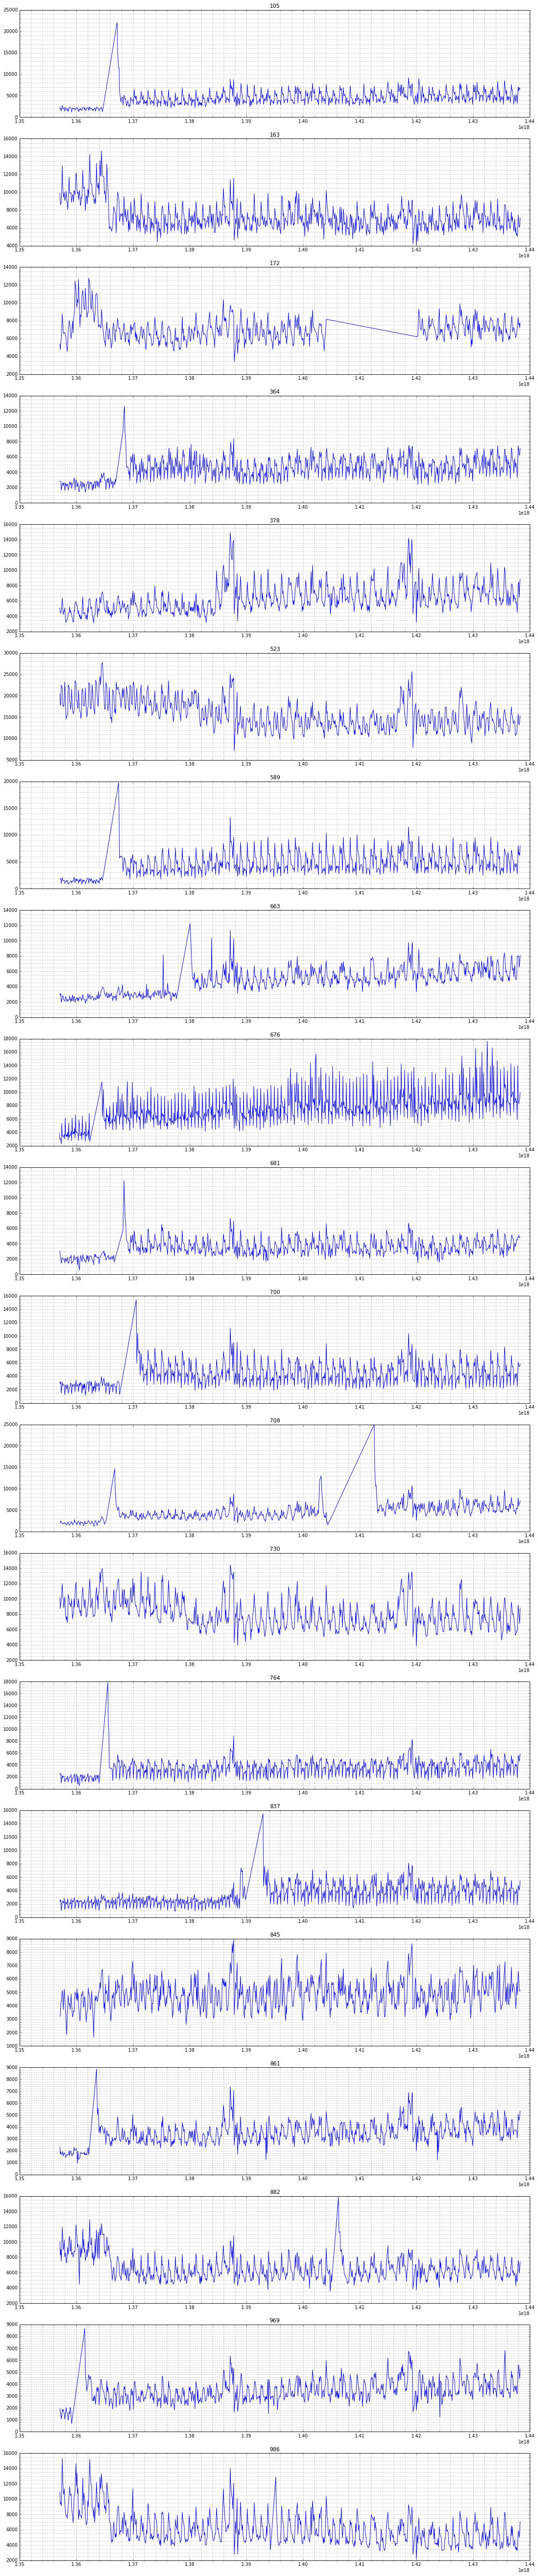

In [47]:
list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

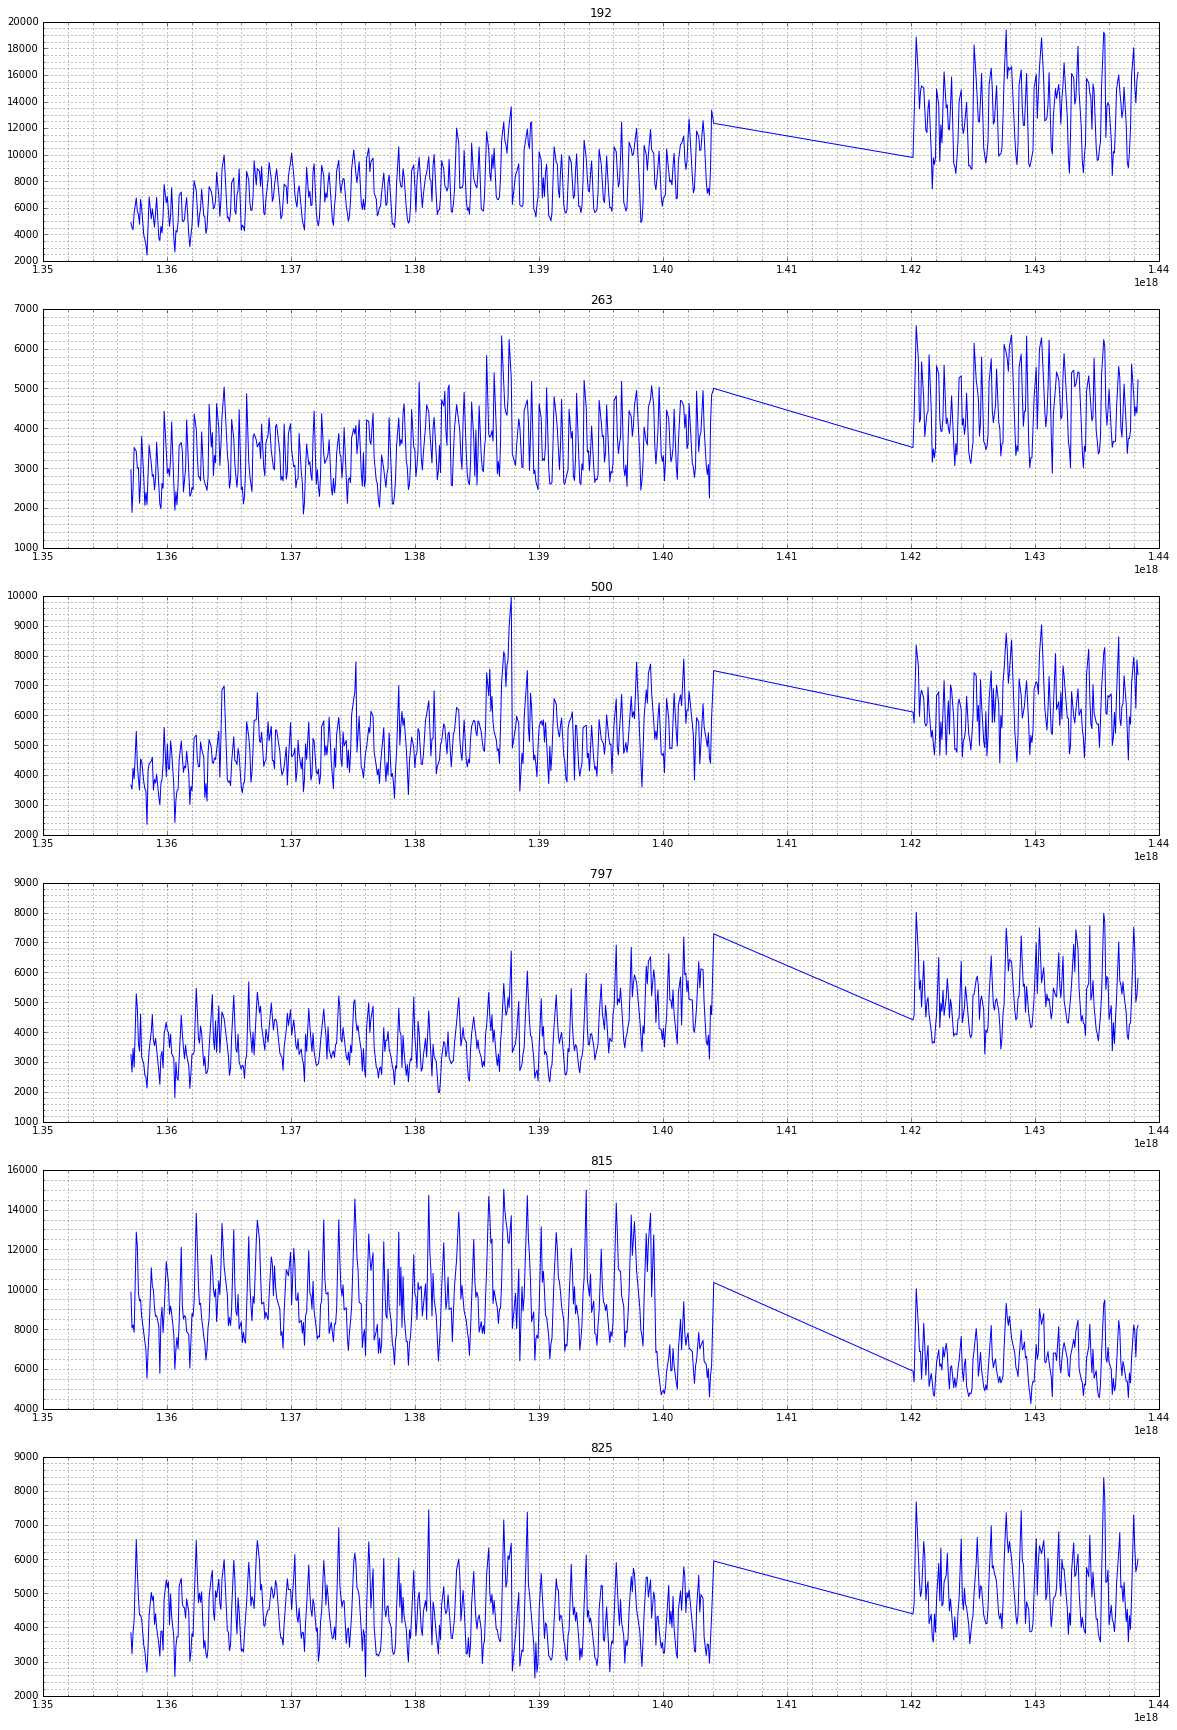

In [48]:
list_stores_to_check = [192,263,500,797,815,825]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

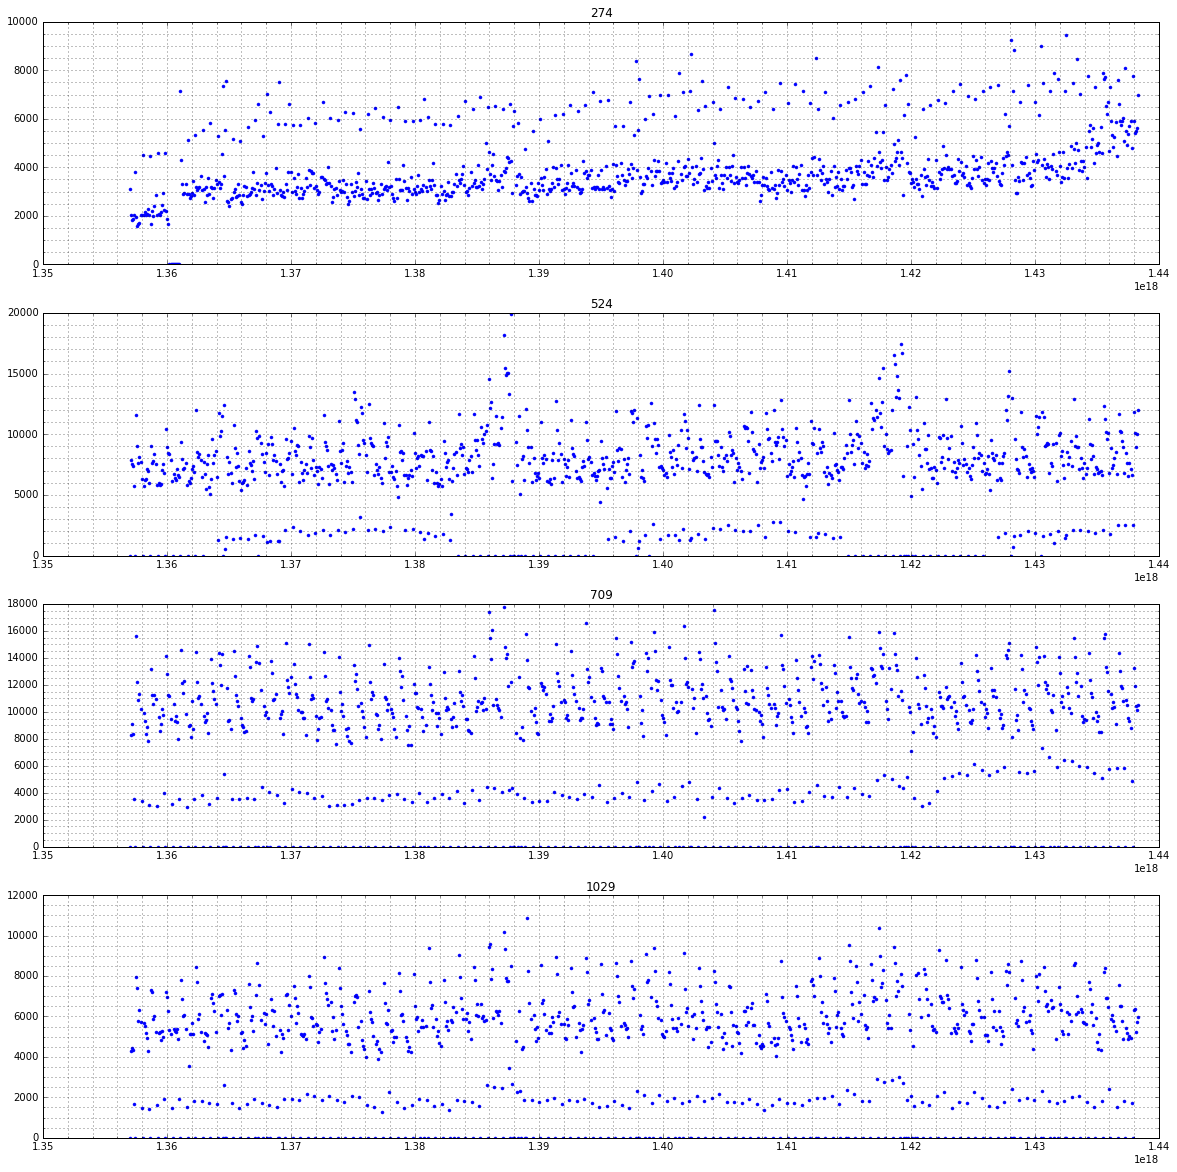

In [49]:
list_stores_to_check = [274,524,709,1029]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '.')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

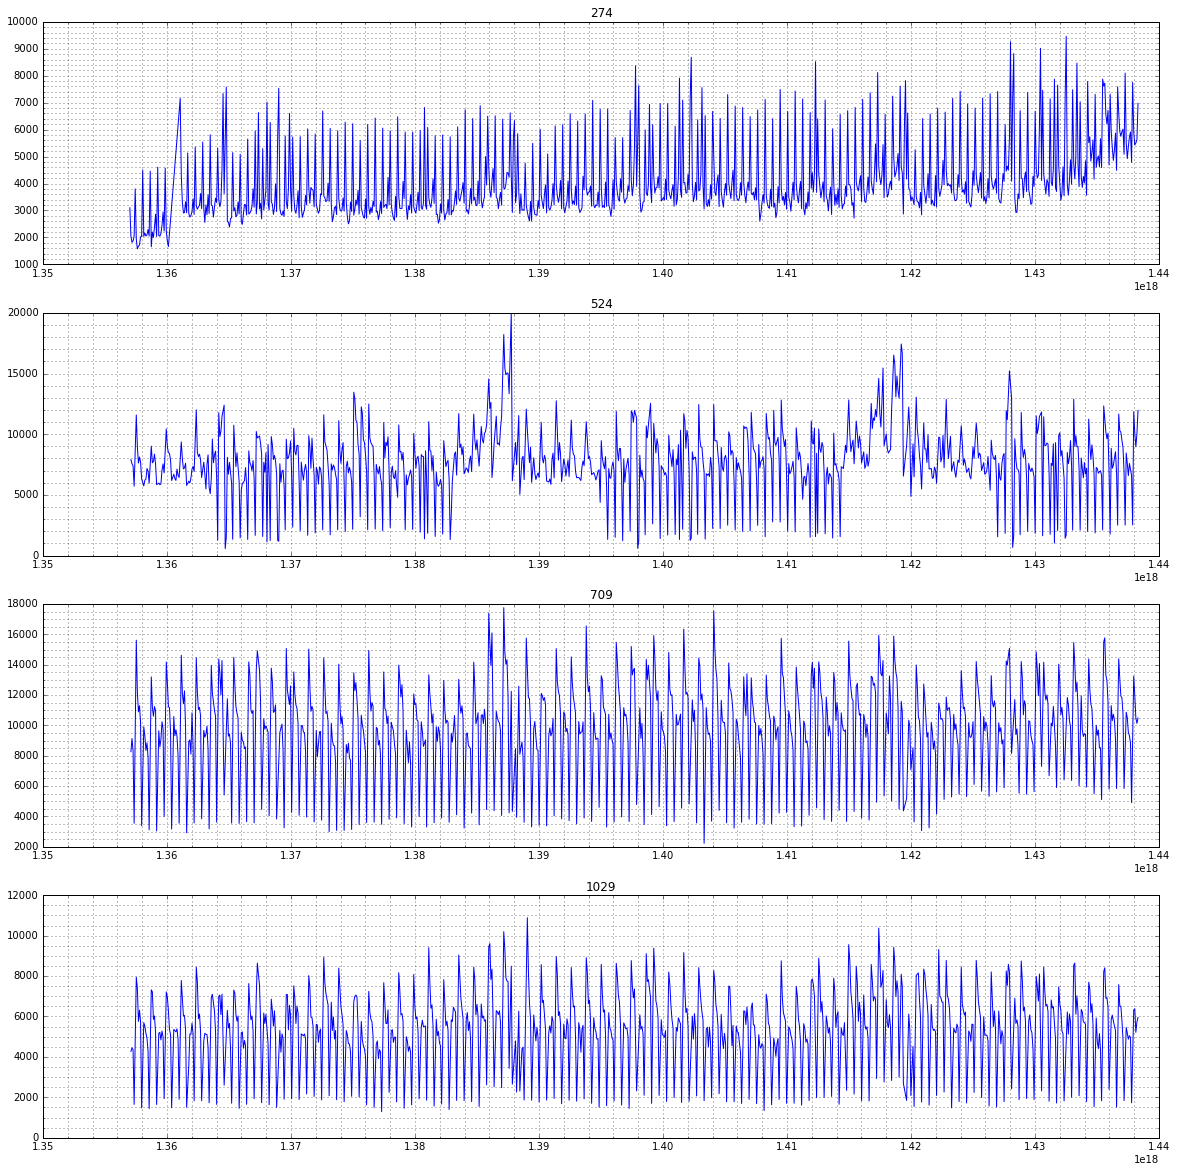

In [50]:

list_stores_to_check = [274,524,709,1029]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

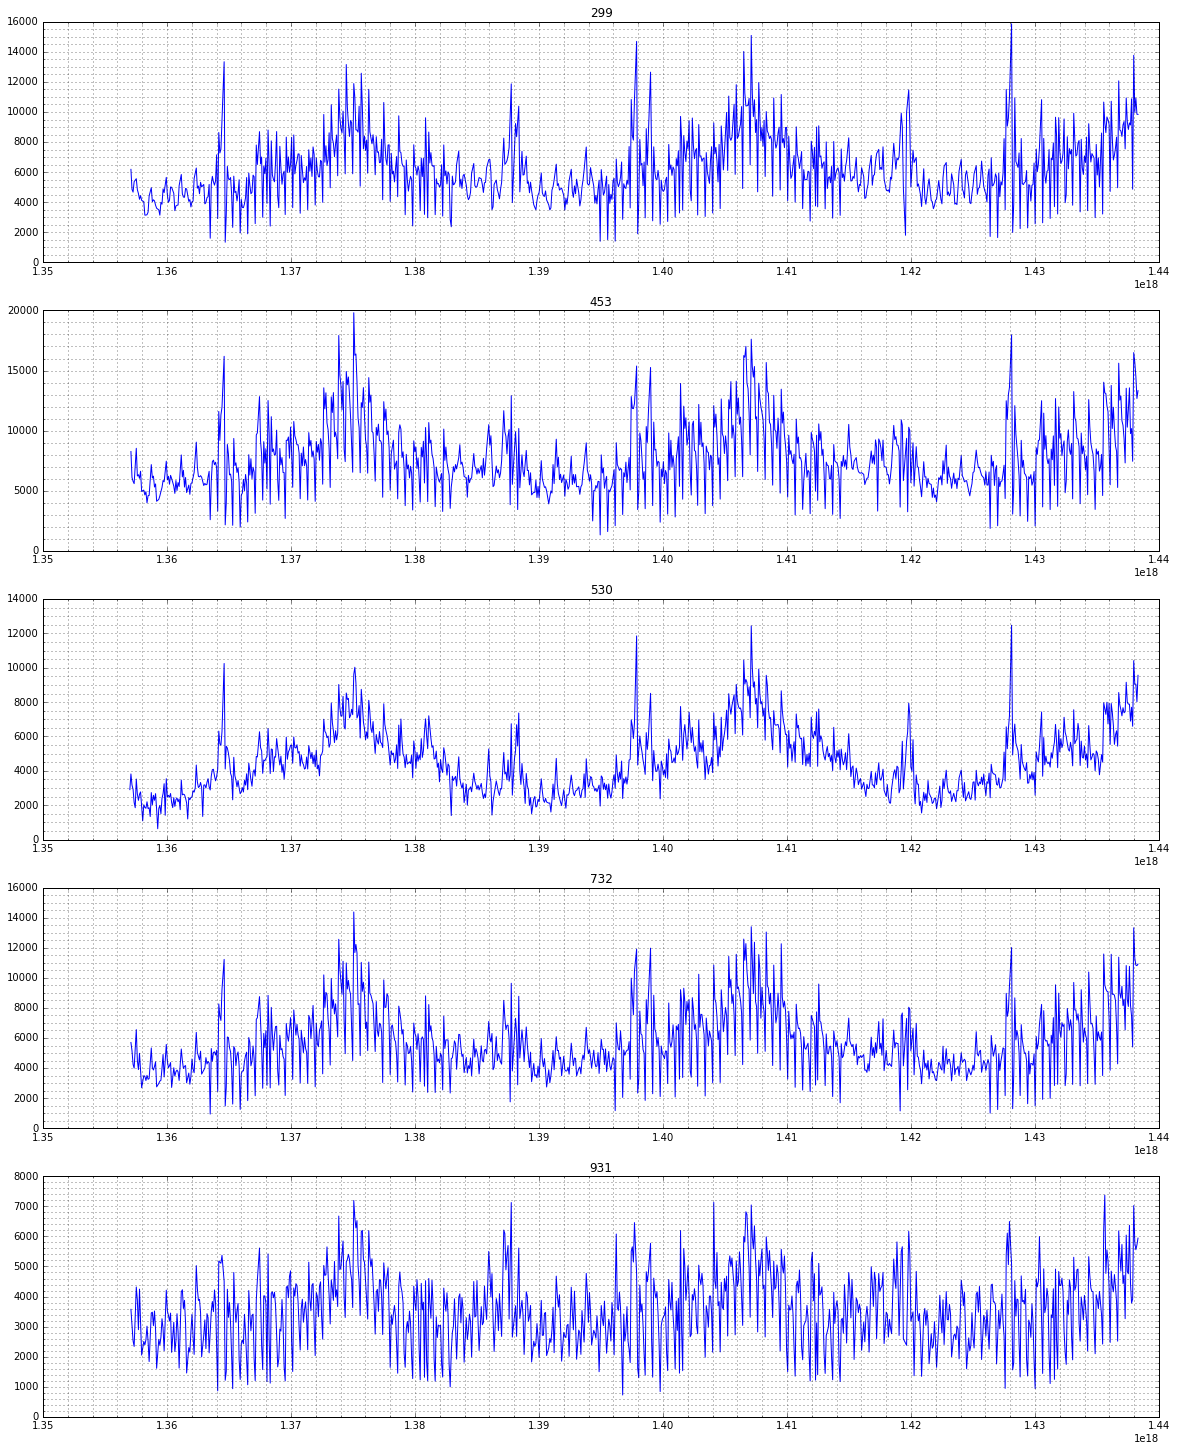

In [51]:
list_stores_to_check = [299,453,530,732,931]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1

In [52]:

store_dates_to_remove = {   105:1.368e18, 163:1.368e18,
                            172:1.366e18, 364:1.37e18,
                            378:1.39e18, 523:1.39e18,
                            589:1.37e18, 663:1.39e18,
                            676:1.366e18, 681:1.37e18,
                            700:1.373e18, 708:1.368e18,
                            709:1.423e18, 730:1.39e18,
                            764:1.368e18, 837:1.396e18,
                            845:1.368e18, 861:1.368e18,
                            882:1.368e18, 969:1.366e18,
                            986:1.368e18, 192:1.421e18,
                            263:1.421e18, 500:1.421e18,
                            797:1.421e18, 815:1.421e18,
                            825:1.421e18}

for key,value in store_dates_to_remove.iteritems():
    df.loc[(df['Store'] == key) & (df['DateInt'] < value), 'Delete'] = True

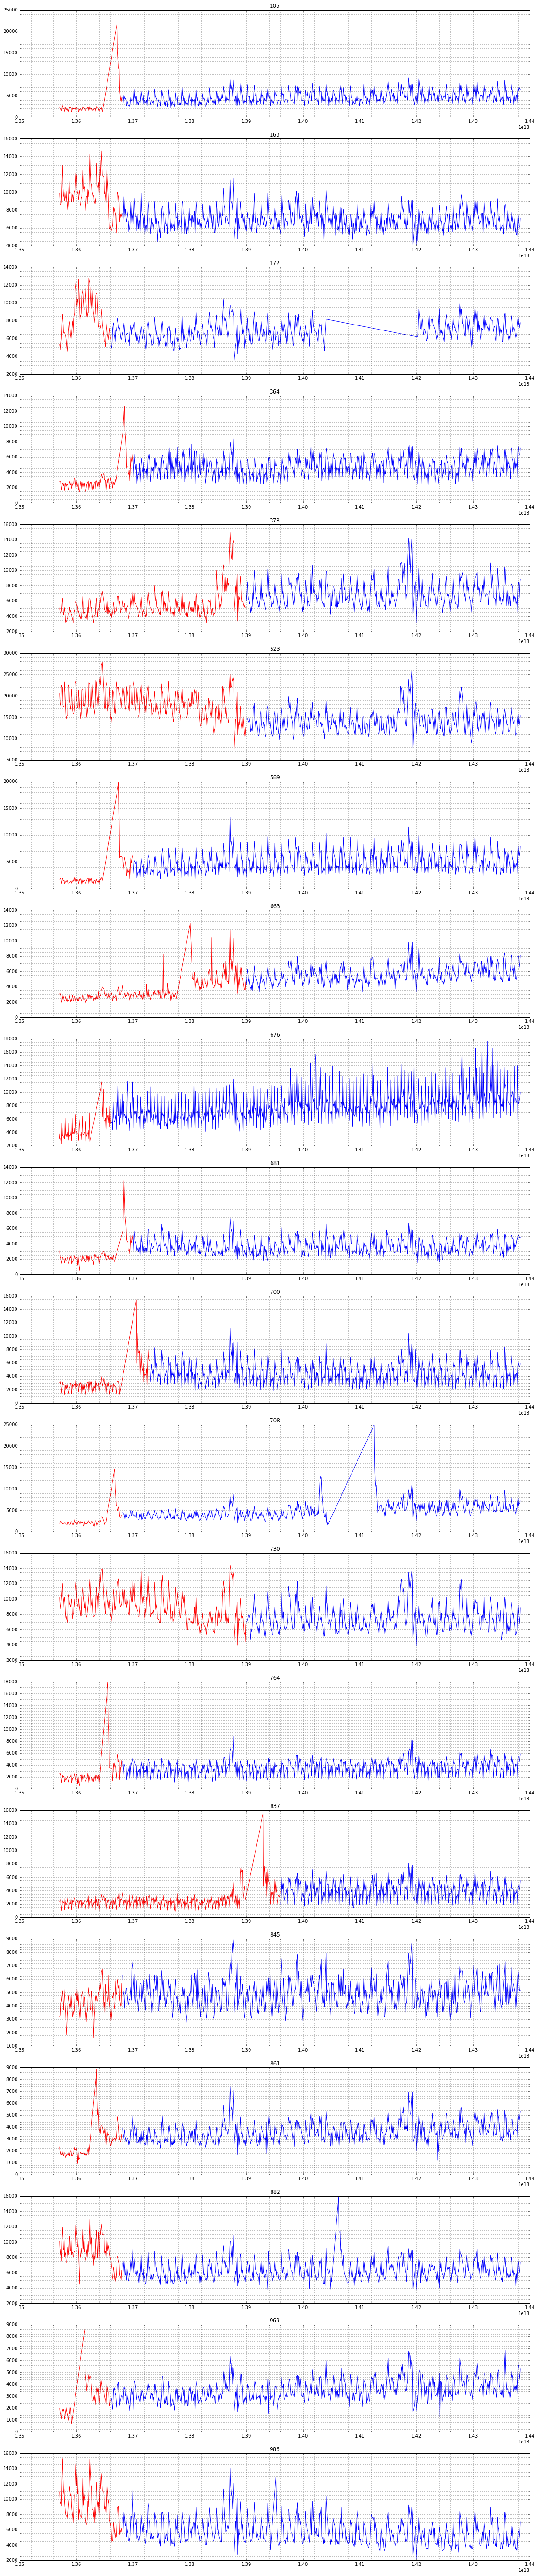

In [53]:
list_stores_to_check = [105,163,172,364,378,523,589,663,676,681,700,708,730,764,837,845,861,882,969,986]

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] == True)]['Sales']
    
    X2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]
    y2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Delete'] != True)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1['DateInt'], y1, 'r-')
    plt.plot(X2['DateInt'], y2, '-')
    plt.minorticks_on()
    plt.grid(True, which='both')
    plt.title(i)
    j += 1


In [54]:
### Delete the data where sales in the first period is much different from the rest
df = df.loc[df['Delete'] != True]

In [55]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


In [56]:

for i in df['Store'].unique():
    df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(df.loc[(df['Set'] == 1) & (df['Store'] == i) & (df['Open'] == 1)]['Sales'], 3)


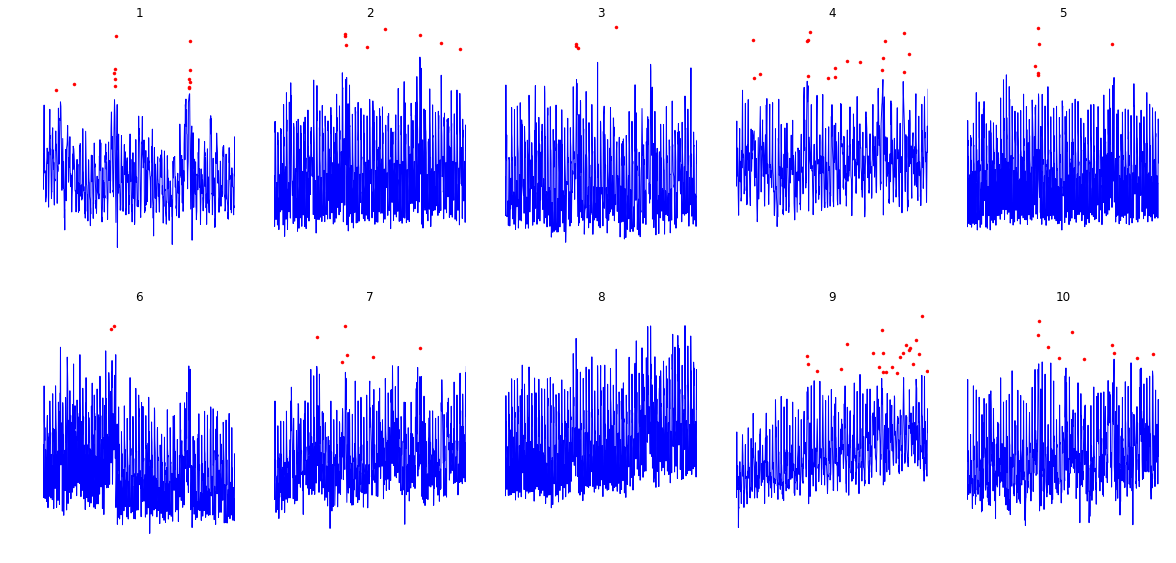

In [57]:
no_stores_to_check = 10

plt.rcParams["figure.figsize"] = [20,no_stores_to_check*5]

for i in range(1,no_stores_to_check+1):
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == False)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == False)]['Sales']

    # Outliers
    X2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == True)]
    y2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == True)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(10,5,i)
    plt.plot(X1['Date'], y1, '-')
    plt.plot(X2['Date'], y2, 'r.')
    plt.title(i)
    plt.axis('off')

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_x],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_y],
                                                    test_size=0.1, random_state=seed)

In [59]:

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [60]:
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [63]:
param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}

plst = param.items()

bst = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

Will train until test error hasn't decreased in 250 rounds.
[0]	train-rmspe:0.999863	test-rmspe:0.999863
[250]	train-rmspe:0.491216	test-rmspe:0.487971
[500]	train-rmspe:0.198972	test-rmspe:0.188309
[750]	train-rmspe:0.166821	test-rmspe:0.156818
[1000]	train-rmspe:0.137129	test-rmspe:0.132996
[1250]	train-rmspe:0.122311	test-rmspe:0.121035
[1500]	train-rmspe:0.109952	test-rmspe:0.112465
[1750]	train-rmspe:0.100481	test-rmspe:0.106788
[2000]	train-rmspe:0.093883	test-rmspe:0.102796
[2250]	train-rmspe:0.088570	test-rmspe:0.100460
[2500]	train-rmspe:0.083871	test-rmspe:0.098587
[2750]	train-rmspe:0.080263	test-rmspe:0.097114
[3000]	train-rmspe:0.077273	test-rmspe:0.095896
[3250]	train-rmspe:0.074326	test-rmspe:0.094886
[3500]	train-rmspe:0.071833	test-rmspe:0.094089
[3750]	train-rmspe:0.069701	test-rmspe:0.093385
[4000]	train-rmspe:0.067834	test-rmspe:0.092811
[4250]	train-rmspe:0.066103	test-rmspe:0.092347
[4500]	train-rmspe:0.064509	test-rmspe:0.091941
[4750]	train-rmspe:0.062960	test-r

In [64]:
dpred = xgb.DMatrix(df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True)][features_x])

In [65]:
ypred_bst = bst.predict(dpred)

In [66]:
df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'SalesLog'] = ypred_bst
df.loc[(df['Set'] == 1) & (df['Open'] == 1) & (df['Outlier'] == True), 'Sales'] = np.exp(ypred_bst) - 1

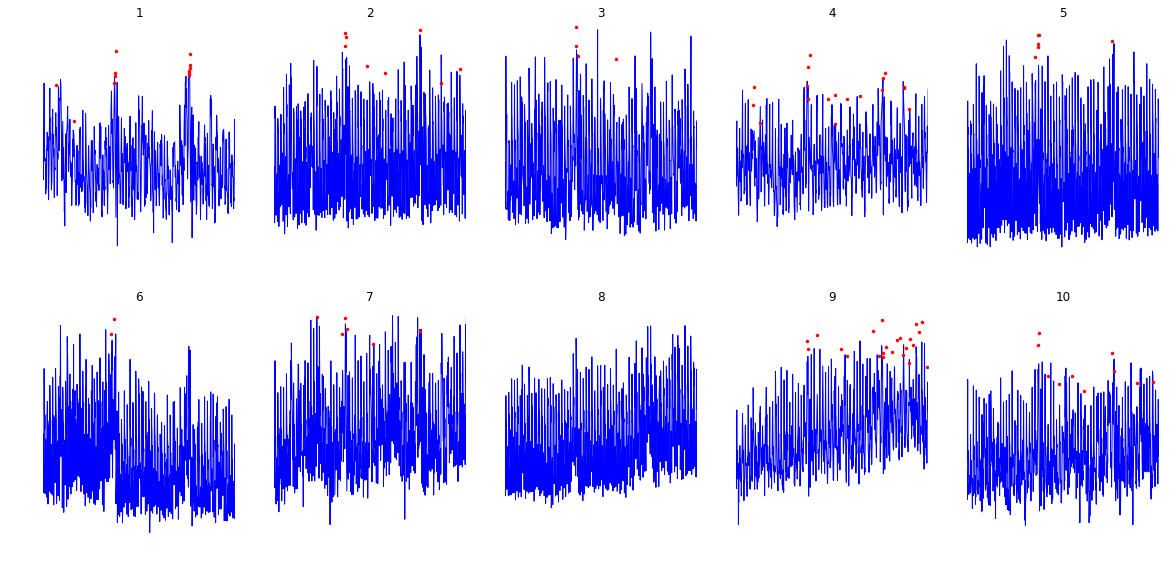

In [67]:

### You see the result being lower than before, but most of them are still pretty high
no_stores_to_check = 10

plt.rcParams["figure.figsize"] = [20,no_stores_to_check*5]

for i in range(1,no_stores_to_check+1):
    stor = i

    # Normal sales
    X1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == False)]
    y1 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == False)]['Sales']

    # Outliers
    X2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == True)]
    y2 = df.loc[(df['Set'] == 1) & (df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == True)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    plt.subplot(10,5,i)
    plt.plot(X1['Date'], y1, '-')
    plt.plot(X2['Date'], y2, 'r.')
    plt.title(i)
    plt.axis('off')

In [68]:

### Get total sales, customers and open days per store
store_data_sales = df.groupby([df['Store']])['Sales'].sum()
store_data_customers = df.groupby([df['Store']])['Customers'].sum()
store_data_open = df.groupby([df['Store']])['Open'].count()

In [69]:

### Calculate sales per day, customers per day and sales per customers per day
store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

In [70]:
df_store = pd.merge(df_store, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])

In [71]:
store_features = ['Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']

features_x = list(set(features_x + store_features))


In [72]:

df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1)][features_x],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1)][features_y],
                                                    test_size=0.1, random_state=seed)

In [74]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [75]:
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [76]:
param = {'bst:max_depth':12,
         'bst:eta':0.0095,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1, 
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}

plst = param.items()

bst1 = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

Will train until test error hasn't decreased in 250 rounds.
[0]	train-rmspe:0.999866	test-rmspe:0.999865
[250]	train-rmspe:0.531137	test-rmspe:0.529227
[500]	train-rmspe:0.137918	test-rmspe:0.131062
[750]	train-rmspe:0.110675	test-rmspe:0.111607
[1000]	train-rmspe:0.100810	test-rmspe:0.106202
[1250]	train-rmspe:0.092724	test-rmspe:0.102566
[1500]	train-rmspe:0.087041	test-rmspe:0.099832
[1750]	train-rmspe:0.082683	test-rmspe:0.097939
[2000]	train-rmspe:0.078698	test-rmspe:0.096432
[2250]	train-rmspe:0.075622	test-rmspe:0.095216
[2500]	train-rmspe:0.072704	test-rmspe:0.094271
[2750]	train-rmspe:0.070362	test-rmspe:0.093525
[3000]	train-rmspe:0.068244	test-rmspe:0.092888
[3250]	train-rmspe:0.066329	test-rmspe:0.092319
[3500]	train-rmspe:0.064502	test-rmspe:0.091857
[3750]	train-rmspe:0.062939	test-rmspe:0.091523
[4000]	train-rmspe:0.061489	test-rmspe:0.091201
[4250]	train-rmspe:0.060084	test-rmspe:0.090915
[4500]	train-rmspe:0.058776	test-rmspe:0.090721
[4750]	train-rmspe:0.057532	test-r

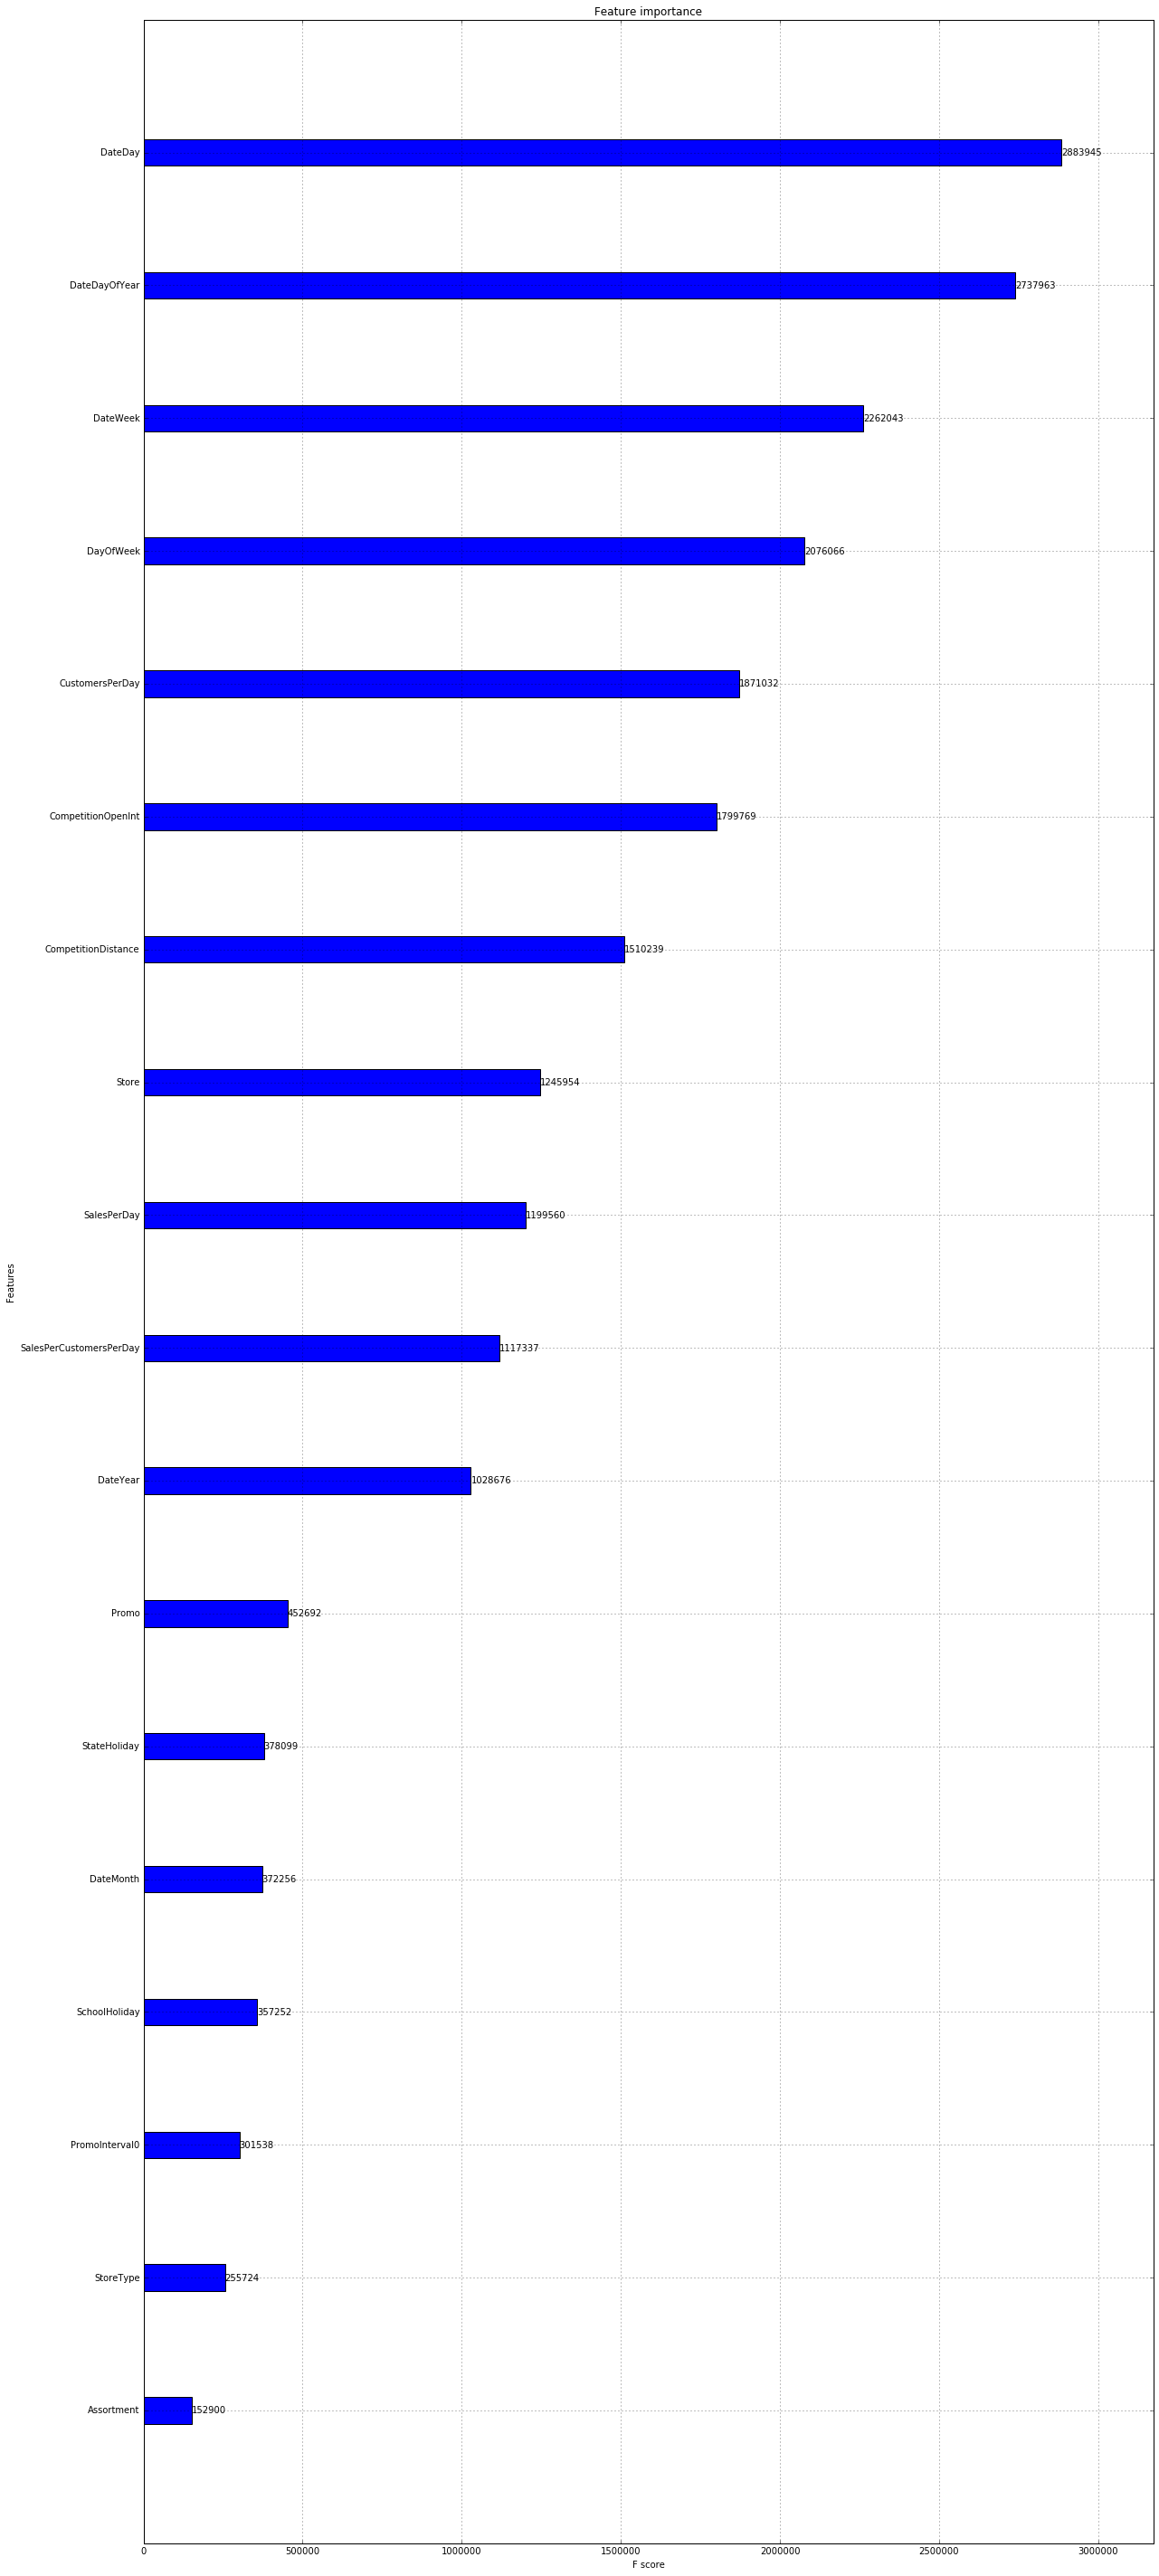

In [81]:
xgb.plot_importance(bst1)

In [78]:

X_submit = df.loc[df['Set'] == 0]

In [79]:

dsubmit = xgb.DMatrix(X_submit[features_x])

In [82]:
ypred_bst = bst1.predict(dsubmit)

df_ypred = X_submit['Id'].reset_index()
del df_ypred['index']
df_ypred['Id'] = df_ypred['Id'].astype('int')

# Scale back the sales a bit
df_ypred['Sales'] = (np.exp(ypred_bst) - 1) * 0.985

df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_best_no_ext_data_scaled.csv', index=False)